### Proj 1
#### Developers' Gender Ratios
#### Based on Stack Overflow Survey 2020
The datasets are available for download here: https://insights.stackoverflow.com/survey<br>
A description of the motivation and findings of the investigation below is available here:<br>
https://aviak.medium.com/developers-gender-ratios-you-may-be-in-for-a-surprise-1fbec813944b

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
#import AllTogether as t
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./survey_results_public_2020.csv')
df_schema = pd.read_csv('./survey_results_schema_2020.csv')
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [2]:
df.shape

(64461, 61)

In [3]:
# list categorical columns
list(df.select_dtypes(include=object).columns)

['MainBranch',
 'Hobbyist',
 'Age1stCode',
 'CompFreq',
 'Country',
 'CurrencyDesc',
 'CurrencySymbol',
 'DatabaseDesireNextYear',
 'DatabaseWorkedWith',
 'DevType',
 'EdLevel',
 'Employment',
 'Ethnicity',
 'Gender',
 'JobFactors',
 'JobSat',
 'JobSeek',
 'LanguageDesireNextYear',
 'LanguageWorkedWith',
 'MiscTechDesireNextYear',
 'MiscTechWorkedWith',
 'NEWCollabToolsDesireNextYear',
 'NEWCollabToolsWorkedWith',
 'NEWDevOps',
 'NEWDevOpsImpt',
 'NEWEdImpt',
 'NEWJobHunt',
 'NEWJobHuntResearch',
 'NEWLearn',
 'NEWOffTopic',
 'NEWOnboardGood',
 'NEWOtherComms',
 'NEWOvertime',
 'NEWPurchaseResearch',
 'NEWPurpleLink',
 'NEWSOSites',
 'NEWStuck',
 'OpSys',
 'OrgSize',
 'PlatformDesireNextYear',
 'PlatformWorkedWith',
 'PurchaseWhat',
 'Sexuality',
 'SOAccount',
 'SOComm',
 'SOPartFreq',
 'SOVisitFreq',
 'SurveyEase',
 'SurveyLength',
 'Trans',
 'UndergradMajor',
 'WebframeDesireNextYear',
 'WebframeWorkedWith',
 'WelcomeChange',
 'YearsCode',
 'YearsCodePro']

In [4]:
# list numeric columns
list(df.select_dtypes(include=np.number).columns)

['Respondent', 'Age', 'CompTotal', 'ConvertedComp', 'WorkWeekHrs']

In [5]:
# check how many countries are represented
len(df['Country'].unique())

184

In [6]:
# Display Gender field question
list(df_schema[df_schema['Column']=='Gender']['QuestionText'])

['Which of the following describe you, if any? Please check all that apply. If you prefer not to answer, you may leave this question blank.']

In [7]:
# All genders count
df['Gender'].value_counts(dropna=False)

Man                                                            46013
NaN                                                            13904
Woman                                                           3844
Non-binary, genderqueer, or gender non-conforming                385
Man;Non-binary, genderqueer, or gender non-conforming            121
Woman;Non-binary, genderqueer, or gender non-conforming           92
Woman;Man                                                         76
Woman;Man;Non-binary, genderqueer, or gender non-conforming       26
Name: Gender, dtype: int64

__note:__<br>
Gender with NaN value or Undisclosed Gender constitutes a significant share of the data,<br>
for the sake of the genders statustics in this notebook, we will ignore this data,<br>
however, we can keep that in mind for further investigations, which are not in the scope of this exploration.

__Handling categorical column Gender__<br>
Add a column 'Gen3' which merges other gender IDs (not Man or Woman) into one category 'Another Gender ID'.

In [8]:
# add a column 'Gen3' which merger other gender IDs (not Man or Woman) into one category
df_gen = df.dropna(subset= ['Gender'])
df_gen['Gen3'] = df_gen['Gender']
df_gen.loc[~df_gen.Gender.isin(['Man', 'Woman']), 'Gen3'] = 'Another Gender ID'

C:\Users\keiss01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\keiss01\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [9]:
df_gen.shape

(50557, 62)

In [10]:
# 3 genders count
df_gen['Gen3'].value_counts()

Man                  46013
Woman                 3844
Another Gender ID      700
Name: Gen3, dtype: int64

In [11]:
# share of all genders
df_gen['Gender'].value_counts(dropna=False)/df_gen.shape[0]

Man                                                            0.910121
Woman                                                          0.076033
Non-binary, genderqueer, or gender non-conforming              0.007615
Man;Non-binary, genderqueer, or gender non-conforming          0.002393
Woman;Non-binary, genderqueer, or gender non-conforming        0.001820
Woman;Man                                                      0.001503
Woman;Man;Non-binary, genderqueer, or gender non-conforming    0.000514
Name: Gender, dtype: float64

### Questoin 1
#### Gender share by Country
##### What are the gender ratios of the survey respondenta within each country ?
The following section investigates the gender ratio per country for the top 20 countries.

In [12]:
df_gen['Country'].value_counts(dropna=False) 

United States          10490
India                   5415
Germany                 3341
United Kingdom          3274
Canada                  1827
                       ...  
Cape Verde                 1
Guinea                     1
Nauru                      1
Antigua and Barbuda        1
Papua New Guinea           1
Name: Country, Length: 173, dtype: int64

In [13]:
# check if there are countries with NaN value
df_gen['Country'].isnull().sum()

0

In [14]:
# Share by country - top 10
(df_gen.groupby('Country')['Respondent'].count()/(df_gen.shape[0])*100).\
reset_index(name='share').sort_values(by = ['share'], ascending = False).head(10)

,Country,share
165,United States,20.748858
66,India,10.710683
55,Germany,6.608383
163,United Kingdom,6.475859
29,Canada,3.613743
52,France,3.073758
23,Brazil,2.870028
107,Netherlands,2.248947
121,Poland,2.144115
8,Australia,2.031371


In [15]:
# Men share by country - top 10
(df_gen[df_gen['Gen3']=='Man'].groupby('Country')['Respondent'].count()/(df_gen.shape[0])*100).\
reset_index(name='share').sort_values(by = ['share'], ascending = False).head(10)

,Country,share
164,United States,18.149811
65,India,9.893783
54,Germany,6.145539
162,United Kingdom,5.736100
28,Canada,3.192436
51,France,2.810689
22,Brazil,2.693989
106,Netherlands,2.049172
120,Poland,2.035326
7,Australia,1.807860


In [16]:
# Women share by country - top 10
(df_gen[df_gen['Gen3']=='Woman'].groupby('Country')['Respondent'].count()/(df_gen.shape[0])*100).\
reset_index(name='share').sort_values(by = ['share'], ascending = False).head(10)

,Country,share
114,United States,2.148070
42,India,0.731847
112,United Kingdom,0.644817
35,Germany,0.375813
19,Canada,0.348122
33,France,0.209664
6,Australia,0.179995
69,Netherlands,0.170105
16,Brazil,0.152303
85,Romania,0.140436


In [17]:
# Other Gender IDs share by country - top 10
(df_gen[df_gen['Gen3']=='Another Gender ID'].groupby('Country')['Respondent'].count()/(df_gen.shape[0])*100).\
reset_index(name='share').sort_values(by = ['share'], ascending = False).head(10)

,Country,share
77,United States,0.450976
76,United Kingdom,0.094942
25,Germany,0.087030
29,India,0.085053
13,Canada,0.073185
24,France,0.053405
4,Australia,0.043515
69,Sweden,0.029669
47,Netherlands,0.029669
7,Bangladesh,0.025714


In [18]:
# Top 20 countries
df_gen['Country'].value_counts().index[:20]

Index(['United States', 'India', 'Germany', 'United Kingdom', 'Canada',
       'France', 'Brazil', 'Netherlands', 'Poland', 'Australia', 'Spain',
       'Italy', 'Russian Federation', 'Sweden', 'Turkey', 'Pakistan', 'Israel',
       'Switzerland', 'Romania', 'Austria'],
      dtype='object')

In [19]:
# create a df of top 20 countries
top_ctry = list(df_gen['Country'].value_counts().index[:20])
df_top_ctry = df_gen[df_gen['Country'].isin(top_ctry)]

In [20]:
df_top_ctry.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro,Gen3
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27,Man
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8,Man
5,6,I am a developer by profession,No,NaN,14,NaN,NaN,NaN,Germany,European Euro,...,Appropriate in length,NaN,NaN,React.js,NaN,NaN,NaN,6,4,Man
7,8,I am a developer by profession,Yes,36.0,12,Yearly,116000.0,116000.0,United States,United States dollar,...,Appropriate in length,No,"Computer science, computer engineering, or sof...",Django;React.js;Vue.js,Flask,Just as welcome now as I felt last year,39.0,17,13,Man
9,10,I am a developer by profession,Yes,22.0,14,Yearly,25000.0,32315.0,United Kingdom,Pound sterling,...,Appropriate in length,No,Mathematics or statistics,Flask;jQuery,Flask;jQuery,Somewhat more welcome now than last year,36.0,8,4,Man


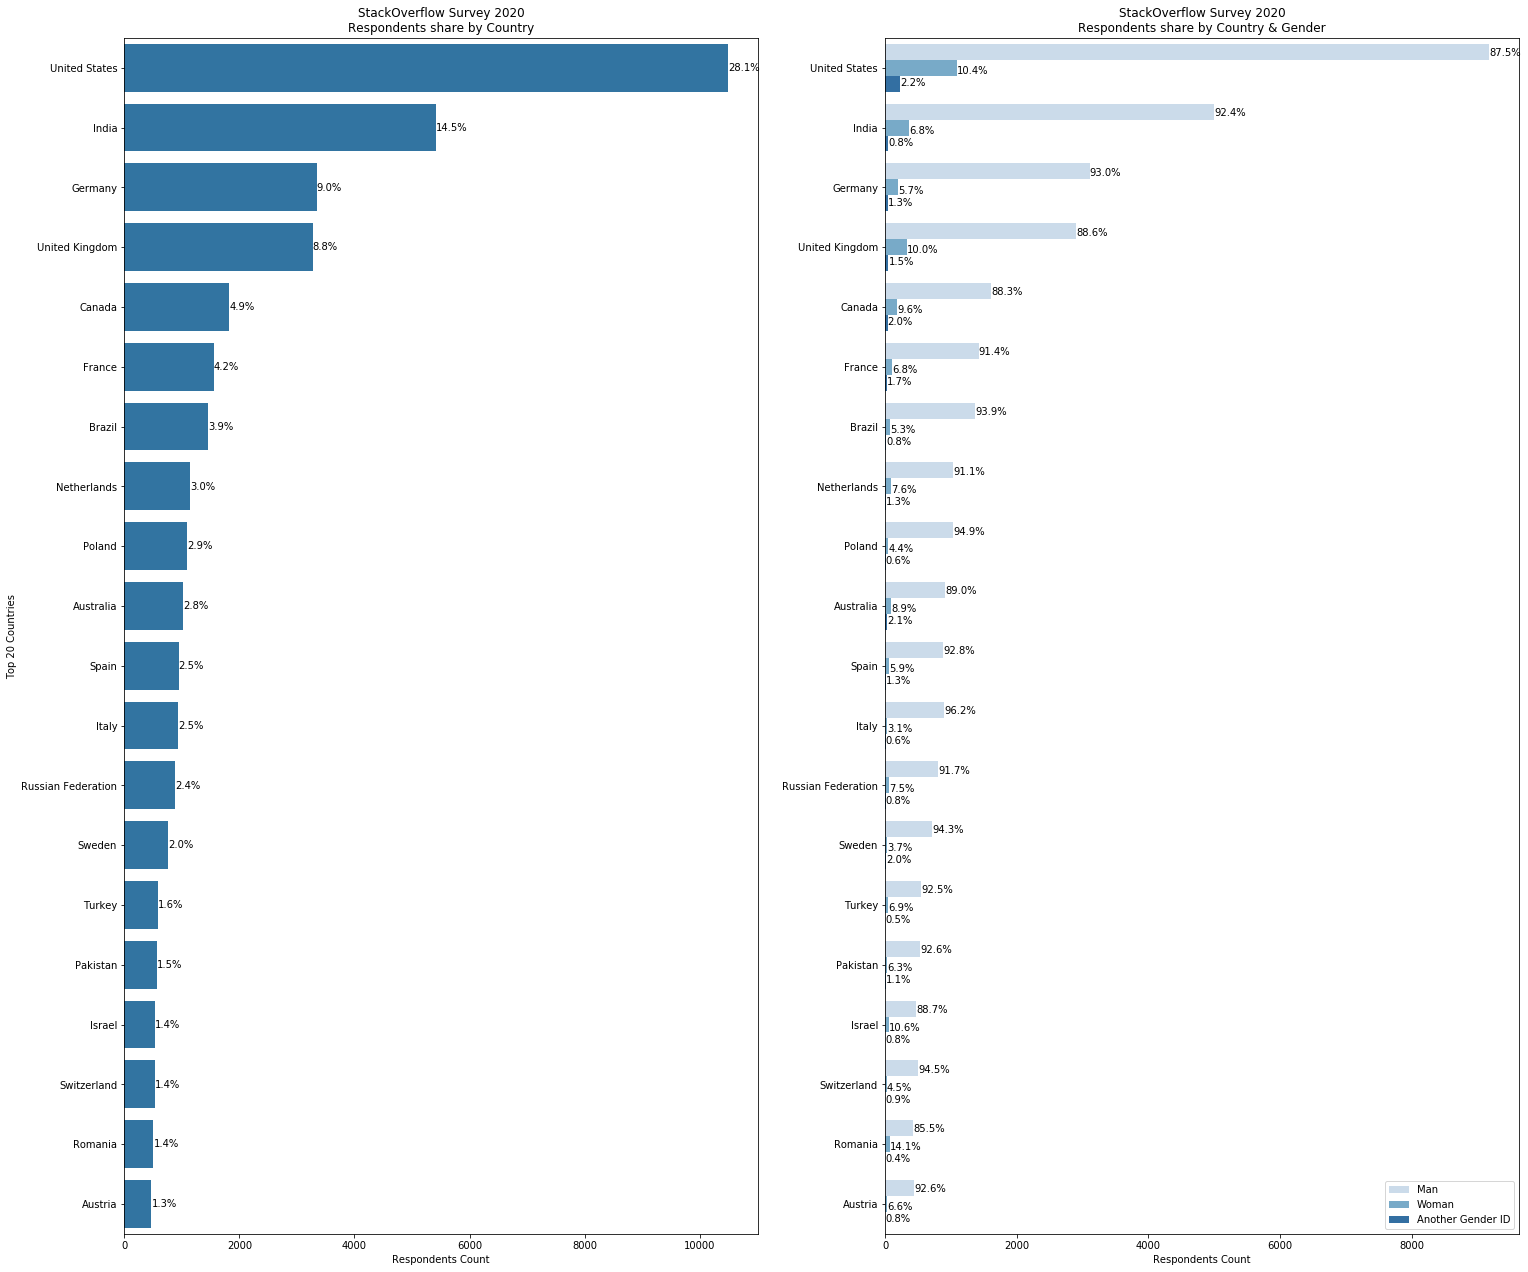

In [21]:
ctry_counts=df_top_ctry['Country'].value_counts()

base_color = sns.color_palette()[0]

plt.figure(figsize=(25, 22))

# plotcount by country
plt.subplot(1, 2, 1)
sns.countplot(data=df_top_ctry, y='Country', color=base_color, orient='h', order=top_ctry)
plt.title('StackOverflow Survey 2020\nRespondents share by Country')
plt.xlabel('Respondents Count')
plt.ylabel('Top 20 Countries')

# add % value to the countplot
for i in range(len(top_ctry)):
    count = ctry_counts[i]
    pct_string = '{:0.1f}%'.format(100*count/df_top_ctry.shape[0])
    plt.text(count+3, i, pct_string, va='center')

# plotcount by gender
plt.subplot(1, 2, 2)
sns.countplot(data=df_top_ctry, y='Country', hue='Gen3', palette='Blues', orient='h', order=top_ctry)
plt.title('StackOverflow Survey 2020\nRespondents share by Country & Gender')
plt.xlabel('Respondents Count')
plt.ylabel('')
plt.legend(loc='lower right')

# add % value to the countplot
genders_shr = df_top_ctry.groupby(['Country', 'Gen3'])['Respondent'].count()/df_top_ctry.groupby(['Country'])['Respondent'].count()
genders_cnt = df_top_ctry.groupby(['Country', 'Gen3'])['Respondent'].count()
genders = ['Man', 'Woman', 'Another Gender ID']
adj_hight = [-0.2, 0.1, 0.3]

for i in range(genders_shr.shape[0]):
    gender = genders[i%3]
    ctry = top_ctry[int(i/3)]
    gen_cnt = genders_cnt[ctry][gender]
    pct_string = '{:0.1f}%'.format(genders_shr[ctry][gender]*100)
    plt.text(gen_cnt+3, int(i/3)+adj_hight[i%3] , pct_string);

It is not surprising to see the quantitative male dominance in the field, however it is interesting to look at the ratios of the other two genders per country. It was unpredictable that the highest (14.1%) would be help by woman in Romania.<br>
Other countries with two digits non-male ratios are Israel, United States and United Kingdom with 10.6%, 10.4% and 10% women ratios respectively.<br>
Another Gender ID group reached or passed the 2% bar in United States, Australia, Canada and Sweden.<br>
Below 6% women ratio we can find Spain, Germany, Brazil, Poland, Switzerland, Sweden, and Italy (In descending order), while above it we can find Canada, Australia, Netherlands, Russia, Turkey, France, India, Austria and Pakistan.

### Question 2
#### Income by Gender
##### How does the income distribution vary by gender ?
The following section investigates income distribution by gender.

In [22]:
# Display Income field ConvertedComp question
list(df_schema[df_schema['Column']=='ConvertedComp']['QuestionText'])

['Salary converted to annual USD salaries using the exchange rate on 2020-02-19, assuming 12 working months and 50 working weeks.']

In [23]:
# Display Income field ConvertedComp question
list(df_schema[df_schema['Column']=='CompTotal']['QuestionText'])

['What is your current total compensation (salary, bonuses, and perks, before taxes and deductions), in `CurrencySymbol`? Please enter a whole number in the box below, without any punctuation. If you are paid hourly, please estimate an equivalent weekly, monthly, or yearly salary. If you prefer not to answer, please leave the box empty.']

In [24]:
# Undisclosed income
df_gen['ConvertedComp'].isna().sum()

18430

In [25]:
# create dataframes per genders with income data
df_income = df_gen.dropna(subset=['ConvertedComp'], axis=0)
df_income_m = df_income[df_income['Gender'] == 'Man']
df_income_w = df_income[df_income['Gender'] == 'Woman']
df_income_o = df_income[~df_income['Gender'].isin(['Man', 'Woman'])]

In [26]:
# Share of respondents with income data by gender
print('All:', df_income.shape, '{:0.1f}%'.format(df_income.shape[0]/df_income.shape[0]*100))
print('Men:', df_income_m.shape, '{:0.1f}%'.format(df_income_m.shape[0]/df_income.shape[0]*100))
print('Women:', df_income_w.shape, '{:0.1f}%'.format(df_income_w.shape[0]/df_income.shape[0]*100))
print('Another Gender ID:', df_income_o.shape, '{:0.1f}%'.format(df_income_o.shape[0]/df_income.shape[0]*100))

All: (32127, 62) 100.0%
Men: (29437, 62) 91.6%
Women: (2274, 62) 7.1%
Another Gender ID: (416, 62) 1.3%


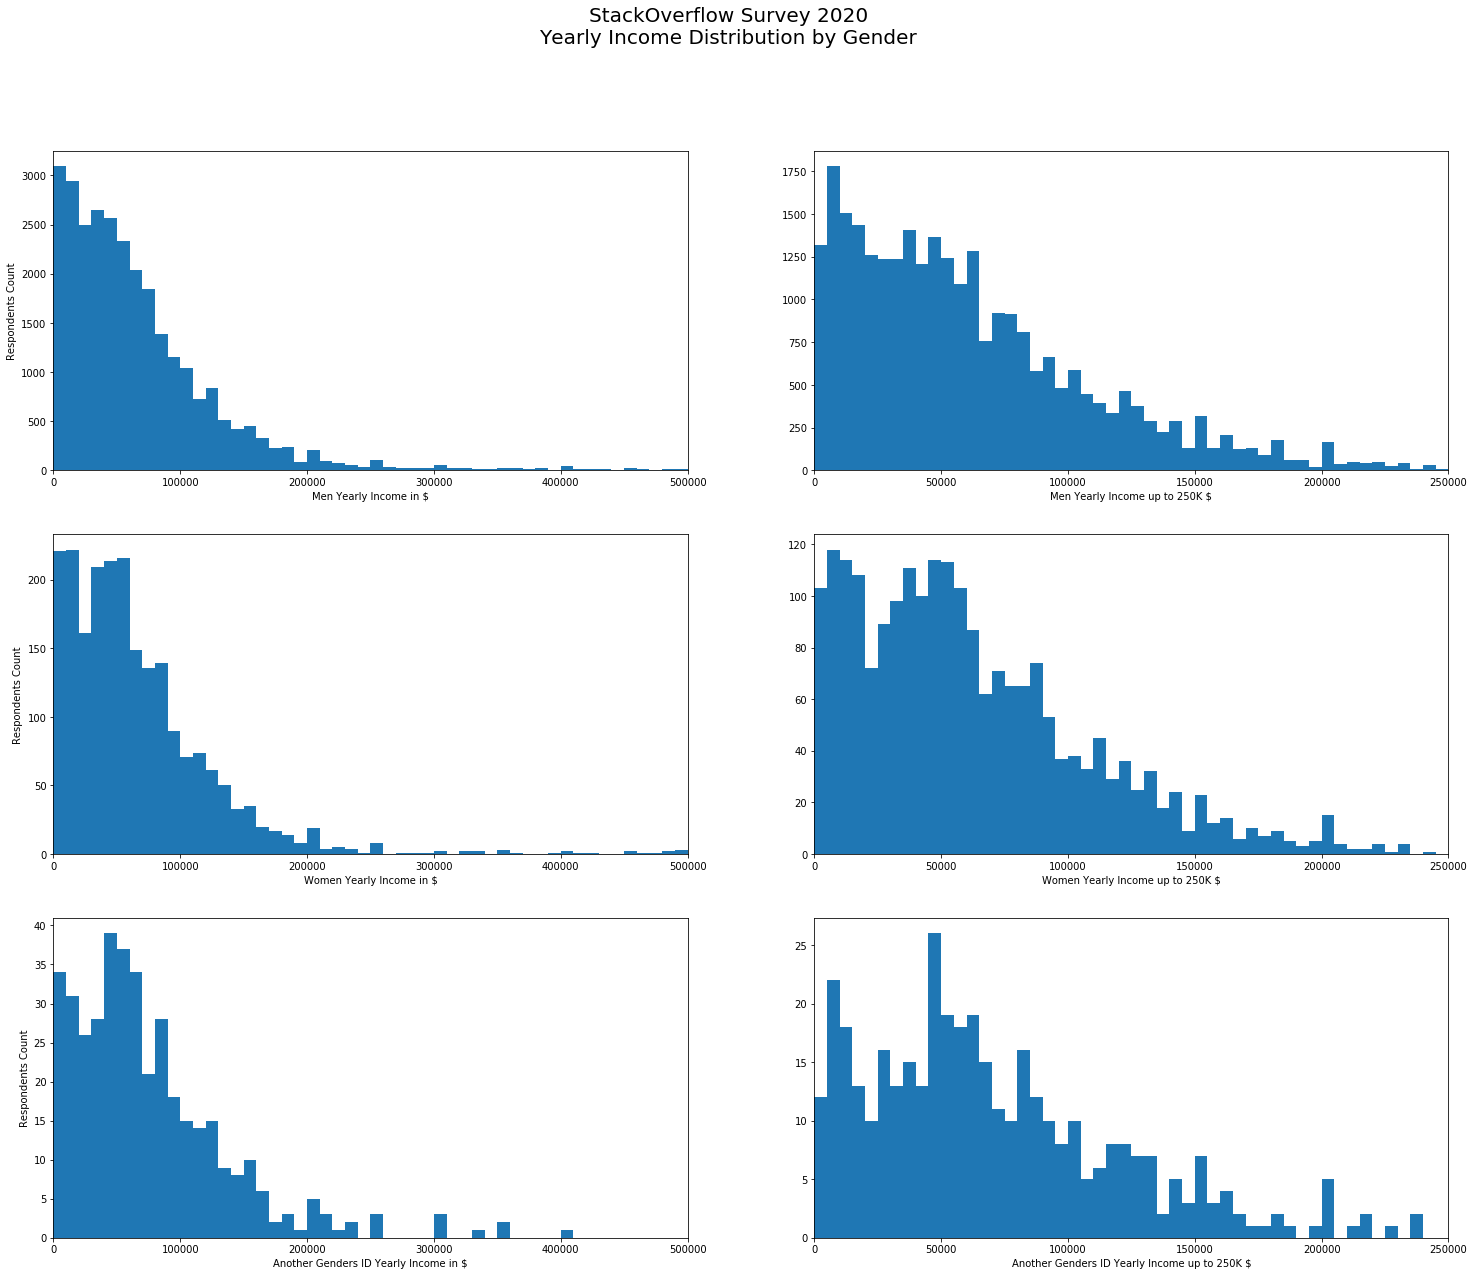

In [27]:
plt.figure(figsize=(25,20))
plt.suptitle('StackOverflow Survey 2020\nYearly Income Distribution by Gender', size=20)

# hist men income

plt.subplot(3, 2, 1)
plt.hist(data=df_income_m, x='ConvertedComp', bins=200)
plt.xlabel('Men Yearly Income in $')
plt.ylabel('Respondents Count')
plt.xlim(0, 500000)

plt.subplot(3, 2, 2)
plt.hist(data=df_income_m, x='ConvertedComp', bins=400)
plt.xlabel('Men Yearly Income up to 250K $')
plt.xlim(0, 250000)

# hist women income

plt.subplot(3, 2, 3)
plt.hist(data=df_income_w, x='ConvertedComp', bins=200)
plt.xlabel('Women Yearly Income in $')
plt.ylabel('Respondents Count')
plt.xlim(0, 500000)

plt.subplot(3, 2, 4)
plt.hist(data=df_income_w, x='ConvertedComp', bins=400)
plt.xlabel('Women Yearly Income up to 250K $')
plt.xlim(0, 250000)

# hist another gender ID income

plt.subplot(3, 2, 5)
plt.hist(data=df_income_o, x='ConvertedComp', bins=200)
plt.xlabel('Another Genders ID Yearly Income in $')
plt.ylabel('Respondents Count')
plt.xlim(0, 500000)

plt.subplot(3, 2, 6)
plt.hist(data=df_income_o, x='ConvertedComp', bins=400)
plt.xlabel('Another Genders ID Yearly Income up to 250K $')
plt.xlim(0, 250000);

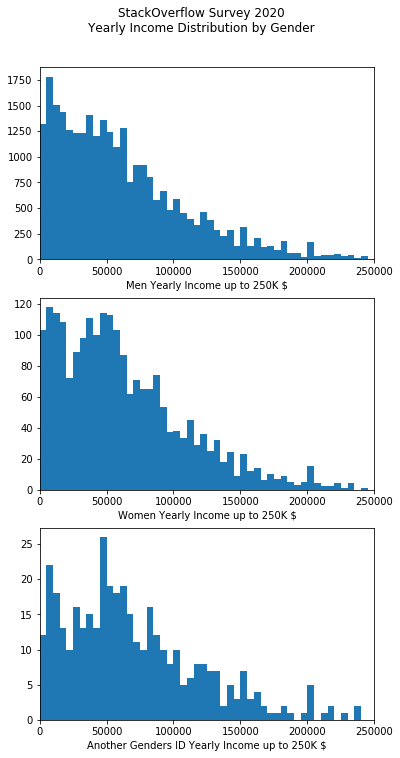

In [28]:
# get only the 3 zoom-in geaphs for the post
plt.figure(figsize=(6,12))
plt.suptitle('StackOverflow Survey 2020\nYearly Income Distribution by Gender', size=12, y=0.95)

# hist men income
plt.subplot(3, 1, 1)
plt.hist(data=df_income_m, x='ConvertedComp', bins=400)
plt.xlabel('Men Yearly Income up to 250K $')
plt.xlim(0, 250000)

# hist women income
plt.subplot(3, 1, 2)
plt.hist(data=df_income_w, x='ConvertedComp', bins=400)
plt.xlabel('Women Yearly Income up to 250K $')
plt.xlim(0, 250000)

# hist another gender ID income
plt.subplot(3, 1, 3)
plt.hist(data=df_income_o, x='ConvertedComp', bins=400)
plt.xlabel('Another Genders ID Yearly Income up to 250K $')
plt.xlim(0, 250000);

In [29]:
# Men income stat
df_income_m['ConvertedComp'].describe().apply(lambda x: format(x, '.2f'))

count      29437.00
mean      103615.91
std       225780.02
min            0.00
25%        25164.00
50%        54049.00
75%        95000.00
max      2000000.00
Name: ConvertedComp, dtype: object

In [30]:
# Woen income stat
df_income_w['ConvertedComp'].describe().apply(lambda x: format(x, '.2f'))

count       2274.00
mean       98300.48
std       213911.00
min            0.00
25%        27612.00
50%        54632.00
75%        92601.50
max      2000000.00
Name: ConvertedComp, dtype: object

In [31]:
# Another Gender ID income stat
df_income_o['ConvertedComp'].describe().apply(lambda x: format(x, '.2f'))

count        416.00
mean      107977.58
std       187682.62
min            0.00
25%        35479.00
50%        64744.50
75%       110000.00
max      2000000.00
Name: ConvertedComp, dtype: object

In [32]:
# display .85 quartile by gender
print('Men .85 quartile:', format(df_income_m['ConvertedComp'].quantile(q=0.85), '.2f'))
print('Women .85 quartile:', format(df_income_w['ConvertedComp'].quantile(q=0.85), '.2f'))
print('Another Gender ID .85 quartile:', format(df_income_o['ConvertedComp'].quantile(q=0.85), '.2f'))

Men .85 quartile: 129259.00
Women .85 quartile: 122791.00
Another Gender ID .85 quartile: 144600.00


In [33]:
# display .95 quartile by gender
print('Men .95 quartile:', format(df_income_m['ConvertedComp'].quantile(q=0.85), '.2f'))
print('Women .95 quartile:', format(df_income_w['ConvertedComp'].quantile(q=0.85), '.2f'))
print('Another Genders .95 quartile:', format(df_income_o['ConvertedComp'].quantile(q=0.85), '.2f'))

Men .95 quartile: 129259.00
Women .95 quartile: 122791.00
Another Genders .95 quartile: 144600.00


In [34]:
# All genders mean income
df_income.groupby('Gender')['ConvertedComp'].mean().reset_index(name='mean_inc').sort_values(by=['mean_inc'], ascending = False)

,Gender,mean_inc
5,"Woman;Man;Non-binary, genderqueer, or gender n...",254225.700000
2,"Non-binary, genderqueer, or gender non-conforming",116016.975410
0,Man,103615.911778
3,Woman,98300.480651
6,"Woman;Non-binary, genderqueer, or gender non-c...",89008.363636
1,"Man;Non-binary, genderqueer, or gender non-con...",88912.375000
4,Woman;Man,76289.777778


The group that consistently holds the highest average and high percentiles incomes is Another Gender ID.

### Question 3
#### Job Satisfaction Level by Gender
##### What are the ojb satisfaction levels by gender ?
The following section investigates the differences in job satisfaction levels by gender.

In [35]:
# Display Job Satisfaction Question
list(df_schema[df_schema['Column']=='JobSat']['QuestionText'])

['How satisfied are you with your current job? (If you work multiple jobs, answer for the one you spend the most hours on.)']

In [36]:
# JobSat with NaN value
df_gen['JobSat'].isna().sum()

10828

In [37]:
# create a dataframe excluding empty JobSat
df_sat = df_gen.dropna(subset=['JobSat'])
df_sat['JobSat'].isna().sum()

0

In [38]:
# check JobSat value counts
df_sat['JobSat'].value_counts()

Very satisfied                        12933
Slightly satisfied                    12281
Slightly dissatisfied                  6363
Neither satisfied nor dissatisfied     4932
Very dissatisfied                      3220
Name: JobSat, dtype: int64

In [39]:
# JobSaz value counts by gender
df_sat.groupby(['JobSat', 'Gen3'])['Respondent'].count()

JobSat                              Gen3             
Neither satisfied nor dissatisfied  Another Gender ID       66
                                    Man                   4545
                                    Woman                  321
Slightly dissatisfied               Another Gender ID       78
                                    Man                   5809
                                    Woman                  476
Slightly satisfied                  Another Gender ID      123
                                    Man                  11281
                                    Woman                  877
Very dissatisfied                   Another Gender ID       49
                                    Man                   2957
                                    Woman                  214
Very satisfied                      Another Gender ID      173
                                    Man                  11730
                                    Woman                 1030
N

In [40]:
# share of gender per Job Satisfaction level
df_sat.groupby(['JobSat', 'Gen3'])['Respondent'].count()/df_sat.groupby(['Gen3'])['Respondent'].count()

JobSat                              Gen3             
Neither satisfied nor dissatisfied  Another Gender ID    0.134969
                                    Man                  0.125131
                                    Woman                0.110007
Slightly dissatisfied               Another Gender ID    0.159509
                                    Man                  0.159931
                                    Woman                0.163125
Slightly satisfied                  Another Gender ID    0.251534
                                    Man                  0.310583
                                    Woman                0.300548
Very dissatisfied                   Another Gender ID    0.100204
                                    Man                  0.081411
                                    Woman                0.073338
Very satisfied                      Another Gender ID    0.353783
                                    Man                  0.322945
                      

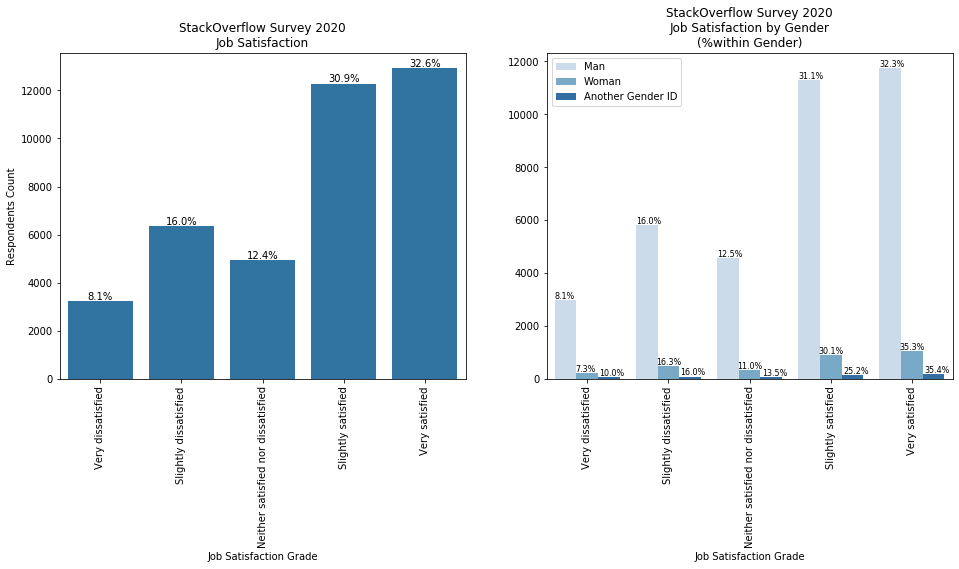

In [41]:
sat_scale = ['Very dissatisfied', 'Slightly dissatisfied', 'Neither satisfied nor dissatisfied', \
             'Slightly satisfied', 'Very satisfied']

sat_counts=df_sat['JobSat'].value_counts()

base_color = sns.color_palette()[0]

plt.figure(figsize=(16, 6))
#plt.tight_layout(pad=10)

# plotcount by Job Satisfaction

plt.subplot(1, 2, 1)
sns.countplot(data=df_sat, x='JobSat', color=base_color, order=sat_scale)
plt.title('StackOverflow Survey 2020\nJob Satisfaction')
plt.xlabel('Job Satisfaction Grade')
plt.xticks(rotation='vertical')
plt.ylabel('Respondents Count')

# add % value to the countplot
for i in range(len(sat_scale)):
    count = sat_counts[sat_scale[i]]
    pct_string = '{:0.1f}%'.format(100*count/df_sat.shape[0])
    plt.text(i, count+1, pct_string, ha='center', va='bottom');

# plotcount by gender
plt.subplot(1, 2, 2)
sns.countplot(data=df_sat, x='JobSat', hue='Gen3', palette='Blues', order=sat_scale)
plt.title('StackOverflow Survey 2020\nJob Satisfaction by Gender\n(%within Gender)')
plt.xlabel('Job Satisfaction Grade')
plt.xticks(rotation='vertical')
plt.ylabel('')
plt.legend(loc='upper left')

# add % value to the countplot
genders_shr = df_sat.groupby(['JobSat', 'Gen3'])['Respondent'].count()/df_sat.groupby(['Gen3'])['Respondent'].count()
genders_cnt = df_sat.groupby(['JobSat', 'Gen3'])['Respondent'].count()
genders = ['Man', 'Woman', 'Another Gender ID']
adj_width = [-0.4, -0.15, 0.15]

for i in range(genders_shr.shape[0]):
    gender = genders[i%3]
    sat = sat_scale[int(i/3)]
    gen_cnt = genders_cnt[sat][gender]
    pct_string = '{:0.1f}%'.format(genders_shr[sat][gender]*100)
    plt.text(int(i/3)+adj_width[i%3], gen_cnt, pct_string, va='bottom', fontsize=8);

Despite having the lowest average income among the genders (see question above), women are the group with the highest share of positive job satisfaction levels (slightly+very satisfied).

#### Conclusion
The analyzed data refers to StackOverflow users, who participated in the survey and were willing to share their information. We should be careful to refrain from making general conclusions regarding developers or the situation in the industry based on it.<br>
With this caveat in mind, the gender ratios by countries yields a rather unexpected countries ranking.<br>
The finding that women have the highest share of positive job satisfaction despite having the lowest average and high percentiles income, raises the question: what are the different job satisfaction predictors and how do they differ between the genders? That would be a good question for the next investigation.